In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Statistics

In [3]:
n_x = 1001
phases = range(-1.0, 1.0, n_x) |> collect;

In [4]:
import .PhasorNetworks: spike_current, phase_memory, neuron_constant

In [5]:
# #speed this up by only using active currents
# function spike_current(train::SpikeTrain, t::Real, spk_args::SpikingArgs)
#     #get constants
#     t_window = spk_args.t_window
#     dt = spk_args.dt

#     current_kernel = x -> exp(-1 * (t - x)^2 / (2 * t_window))
#     impulses = current_kernel.(train.times)
    
#     current = zeros(Float32, train.shape)
#     for (idx, impulse) in zip(train.indices, impulses)
#         current[idx] += impulse
#     end

#     return current
# end

In [6]:
function spike_current(train::SpikeTrain, t::Real, spk_args::SpikingArgs; sigma::Real = 9.0)
    #get constants
    t_window = spk_args.t_window
    dt = spk_args.dt

    #find which channels are active 
    times = train.times
    active = (times .> (t - sigma * t_window)) .* (times .< (t + sigma * t_window))
    active_inds = train.indices[active]

    #add currents into the active synapses
    current_kernel = x -> exp(-1 * (t - x)^2 / (2 * t_window))
    impulses = current_kernel.(train.times[active])
    
    current = zeros(Float32, train.shape)
    current[active_inds] .+= impulses

    return current
end

spike_current (generic function with 1 method)

In [40]:
function phase_memory(x::SpikeTrain; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args())
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)

    #set up compartments for each sample
    u0 = zeros(ComplexF32, x.shape)
    #resonate in time with the input spikes
    dzdt(u, p, t) = k .* u .+ spike_current(x, t, spk_args)
    #solve the memory compartment
    prob = ODEProblem(dzdt, u0, tspan)
    sol = solve(prob, spk_args.solver, adaptive=true, abstol = 1e-6, reltol = 1e-6,)

    return sol
end

phase_memory (generic function with 1 method)

In [8]:
spk_args = SpikingArgs(t_window=0.01, dt = 0.001, solver = Tsit5())

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [9]:
repeats = 6
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [10]:
tbase = collect(tspan[1]:spk_args.dt:tspan[2]);

In [11]:
st = phase_to_train(phases, spk_args, repeats = repeats)

Spike Train: (1001,) with 6006 spikes.

In [41]:
u = phase_memory(st, tspan=tspan, spk_args=spk_args);

In [42]:
typeof(u)

ODESolution{ComplexF32, 2, Vector{Vector{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF32}}}, ODEProblem{Vector{ComplexF32}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt#9"{SpikingArgs, SpikeTrain, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, var"#dzdt#9"{SpikingArgs, SpikeTrain, ComplexF64}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing,

In [44]:
u_arr = Array(u);

In [45]:
size(u_arr)

(1001, 5113)

In [46]:
p_rec = potential_to_phase(u_arr, u.t, dim=2, spk_args=spk_args);

In [47]:
size(p_rec)

(1001, 5113)

In [48]:
err = p_rec[:,end] .- phases;

In [49]:
size(err)

(1001,)

In [50]:
mean(err)

0.00045271890504146366

In [51]:
median(err)

0.00091607430051871

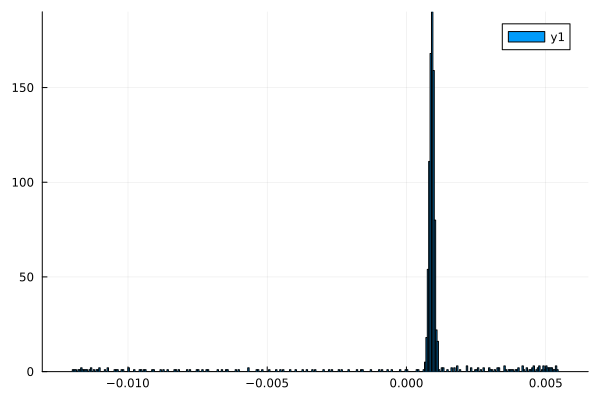

In [52]:
histogram(err)

In [24]:
ang_err = sin.(pi .* err);

In [25]:
median(ang_err)

0.002877928319910674

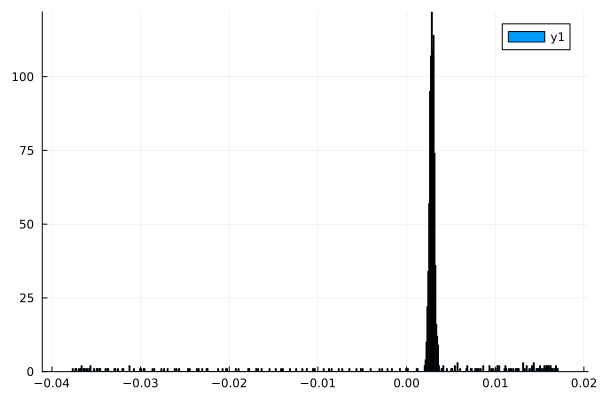

In [26]:
histogram(ang_err)

In [54]:
import .PhasorNetworks: find_spikes_rf

In [57]:
spk_i, spk_t = find_spikes_rf(u, spk_args)

(CartesianIndex{1}[CartesianIndex(1,), CartesianIndex(2,), CartesianIndex(3,), CartesianIndex(4,), CartesianIndex(5,), CartesianIndex(6,), CartesianIndex(7,), CartesianIndex(8,), CartesianIndex(9,), CartesianIndex(10,)  …  CartesianIndex(741,), CartesianIndex(742,), CartesianIndex(743,), CartesianIndex(744,), CartesianIndex(745,), CartesianIndex(746,), CartesianIndex(747,), CartesianIndex(748,), CartesianIndex(749,), CartesianIndex(750,)], [0.2916962076002611, 0.2916962076002611, 0.29293827773771214, 0.29293827773771214, 0.29293827773771214, 0.2943059773368738, 0.2943059773368738, 0.2943059773368738, 0.29556667632716094, 0.29556667632716094  …  5.9896640374815595, 5.990812050723085, 5.992133481731266, 5.9934038577151725, 5.9934038577151725, 5.994734802696655, 5.9958193001810205, 5.996837479225264, 5.997962803867223, 5.999249065638253])

In [60]:
st = SpikeTrain(spk_i, spk_t, (1001,), 0.25)

Spike Train: (1001,) with 5755 spikes.

In [62]:
stp = train_to_phase(st, spk_args)

6×1001 Matrix{Float64}:
 -0.916608  -0.916608  -0.914123  …    0.99709     0.99709     0.999435
 -0.974022  -0.974022  -0.971519       0.996429    0.997723    0.997723
 -0.988124  -0.985191  -0.982287       0.995249    0.998883  NaN
 -0.991028  -0.988877  -0.986685       0.995065    0.997874   -0.999194
 -0.993623  -0.993623  -0.990796       0.994308    0.997089    0.999925
 -0.99507   -0.993063  -0.991009  …  NaN         NaN         NaN

In [66]:
spk_err = stp[end-1,:] .- phases;

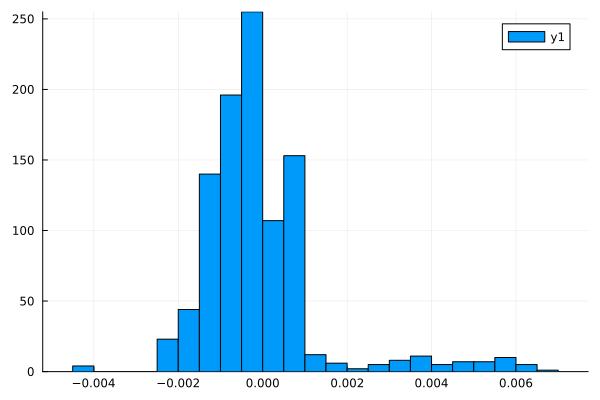

In [67]:
histogram(spk_err)